# Jo Wilder Session Data Exploration

This template is designed to help you explore per-session data from the Jo Wilder game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

# Environment Setup and Import

In [9]:
import os
print(os.getcwd())
!pip install --quiet --no-input -r ../../requirements.txt --log ./pip-installations.log

c:\Users\subsc\Documents\_work\FieldDay\OpenGameData\opengamedata-samples\JOWILDER\explore


In [10]:
# Standard Libraries
import math
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [11]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Retrieve Data Files

#### Please change `OGD_SERVER` and `zip_name` if you want to get a file from a different location.
#### The cells below will error if `OGD_SERVER` and `zip_name` are invalid.

In [12]:
# Configure Server Info

OGD_SERVER = 'http://opengamedata.fielddaylab.wisc.edu/'
SERVER_DATA_PATH = 'data/WAVES/'

dataset_name = "JOWILDER_DATE_to_DATE"
zip_name = f"{dataset_name}_hash_session-features.zip"

In [13]:
# Download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {OGD_SERVER}...")
    file_url = f"{OGD_SERVER}{SERVER_DATA_PATH}{zip_name}"
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")

### Import Data Files to Jupyter

In [14]:
# Open TSV from the zip file.
zip_file = ZipFile(Path(f'./{zip_name}'))
tsv_name = f"{dataset_name}_hash_session-features.tsv"
raw_data = pd.DataFrame()
with zip_file.open(f"{tsv_name}") as tsv_file:
    raw_data = pd.read_csv(tsv_file, sep='\t')
# data_readme = zip_file.read(f"{dataset_name}/readme.md")
zip_file.close()

# Data Overview

### Dataset README

Below, the readme file included with your dataset is displayed.
It includes information on the events and features for Wave Combinator.

In [15]:
# display(Markdown(data_readme.decode()))

### Data "Shape"

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 3553 entries, Unnamed: 0 to persistentSessionID
dtypes: float64(3501), int64(33), object(19)
memory usage: 81.3+ MB


In [17]:
print(f"This dataset has {raw_data.shape[0]} Rows, {raw_data.shape[1]} Columns")

This dataset has 3000 Rows, 3553 Columns


### Column Names

Each Jo Wilder feature data file contains a large number of columns, each representing a single feature of gameplay.
Some features have one column per level, or one column per quiz question.
We call these **per-count** features.
Each **per-count** feature has a prefix indicating whether it was a *per-level* (prefix: `lvl`) *per-interaction* (prefix: `int`), *per-objective* (prefix: `obj`), *per-quiz-question* (prefix: `Q`), or *per-survey-question* (prefix: `SA`).  
Other features have only one column, based on play across all levels.
We call these **aggregate** or **session** features.

Below, the base feature names are listed.
**Per-count** features have the prefix shown in parentheses, and the number of columns with that base feature name shown to the right.
Note that **aggregate** features each have a "1" on the right, since each has just one column.

In [18]:
id_columns = pd.Index(["SessionID", "PlayerID"])

In [26]:
percount_prefixes = ['lvl', 'int', 'obj', 'Q', 'SA', 'R', 'S']
column_groups = {
  pre : []
  for pre in percount_prefixes + ['Aggregate']
}

for col in raw_data.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  found = False
  for pc_pre in percount_prefixes:
    if prefix.startswith(pc_pre):
      column_groups[pc_pre].append(f"({pc_pre}) {pieces[1]}")
      found = True
  if not found:
    column_groups['Aggregate'].append(col)
col_set = Counter(sum(column_groups.values(), []))
print(f"There are {len(raw_data.columns)} columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

There are 3553 columns in 69 groups:
Counter({'(int) ifirst': 1323,
         '(lvl) first': 336,
         '(lvl) count': 192,
         '(lvl) time': 192,
         '(int) itime': 189,
         '(int) inum': 189,
         '(int) itotal': 189,
         '(obj) ocount': 160,
         '(obj) onext': 80,
         '(obj) onum': 80,
         '(obj) omeaningful': 80,
         '(obj) otime': 80,
         '(SA) sa': 72,
         '(lvl) EventCount': 48,
         '(lvl) meaningful': 48,
         '(lvl) avg': 48,
         '(lvl) num': 48,
         '(Q) A1': 38,
         '(Q) A2': 38,
         '(Q) A3': 38,
         '(Q) num': 19,
         '(Q) answers': 19,
         'Unnamed: 0': 1,
         'R0_quiz_response': 1,
         'R1_quiz_response': 1,
         'R2_quiz_response': 1,
         'S0_s_time': 1,
         'S1_s_time': 1,
         'S2_s_time': 1,
         'S3_s_time': 1,
         'sess_count_clicks': 1,
         'sess_count_hovers': 1,
         'sess_meaningful_action_count': 1,
         'sess_Ev

### Sample Rows

In [20]:
ROWS_TO_SHOW = 10

raw_data.head(ROWS_TO_SHOW)

Unnamed: 0  lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
0           0             28.0             36.0             55.0   
1           1             44.0             26.0             39.0   
2           2             21.0             35.0              NaN   
3           3              NaN              NaN              NaN   
4           4             32.0             22.0              NaN   
5           5              1.0              NaN              NaN   
6           6             36.0             40.0             72.0   
7           7             23.0             34.0             33.0   
8           8             27.0             56.0             41.0   
9           9             31.0             30.0             48.0   

   lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  \
0             59.0             83.0             30.0             98.0   
1             94.0             87.0             30.0            150.0   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   
5              NaN              NaN              NaN              NaN   
6              NaN              NaN              NaN              NaN   
7             21.0              NaN              NaN              NaN   
8              NaN              NaN              NaN              NaN   
9             40.0             69.0             42.0             82.0   

   lvl7_EventCount  lvl8_EventCount  lvl9_EventCount  lvl10_EventCount  \
0             48.0             26.0             44.0              18.0   
1             97.0              NaN              NaN               NaN   
2              NaN              NaN              NaN               NaN   
3              NaN              NaN              NaN               NaN   
4              NaN              NaN              NaN               NaN   
5              NaN              NaN              NaN               NaN   
6              NaN              NaN              NaN               NaN   
7              NaN              NaN              NaN               NaN   
8              NaN              NaN              NaN               NaN   
9              5.0              NaN              NaN               NaN   

   lvl11_EventCount  lvl12_EventCount  lvl13_EventCount  lvl14_EventCount  \
0              51.0             349.0              40.0              33.0   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   
5               NaN               NaN               NaN               NaN   
6               NaN               NaN               NaN               NaN   
7               NaN               NaN               NaN               NaN   
8               NaN               NaN               NaN               NaN   
9               NaN               NaN               NaN               NaN   

   lvl15_EventCount  lvl16_EventCount  lvl17_EventCount  lvl18_EventCount  \
0              32.0              44.0              50.0             165.0   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   
5               NaN               NaN               NaN               NaN   
6               NaN               NaN               NaN               NaN   
7               NaN               NaN               NaN               NaN   
8               NaN               NaN               NaN               NaN   
9               N

### Summary of raw data

In [21]:
raw_data.describe(include='all')

Unnamed: 0  lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
count   3000.000000      2512.000000      2197.000000      2046.000000   
unique          NaN              NaN              NaN              NaN   
top             NaN              NaN              NaN              NaN   
freq            NaN              NaN              NaN              NaN   
mean    1499.500000        34.150080        41.330451        54.035679   
std      866.169729        18.855087        24.862977        34.631560   
min        0.000000         1.000000         1.000000         1.000000   
25%      749.750000        25.000000        30.000000        40.000000   
50%     1499.500000        32.000000        36.000000        46.000000   
75%     2249.250000        41.000000        46.000000        56.000000   
max     2999.000000       343.000000       569.000000       396.000000   

        lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  \
count       1866.000000      1334.000000       1183.00000      1129.000000   
unique              NaN              NaN              NaN              NaN   
top                 NaN              NaN              NaN              NaN   
freq                NaN              NaN              NaN              NaN   
mean          73.551983        81.825337         44.89011       122.190434   
std           55.025032        30.186421         40.55966        61.571443   
min            2.000000         1.000000          1.00000         2.000000   
25%           43.000000        68.000000         20.00000        95.000000   
50%           59.000000        77.000000         29.00000       110.000000   
75%           88.000000        90.000000         54.00000       132.000000   
max          828.000000       323.000000        304.00000       831.000000   

        lvl7_EventCount  lvl8_EventCount  lvl9_EventCount  lvl10_EventCount  \
count       1029.000000       902.000000       864.000000        818.000000   
unique              NaN              NaN              NaN               NaN   
top                 NaN              NaN              NaN               NaN   
freq                NaN              NaN              NaN               NaN   
mean          73.613217        43.176275        60.672454         25.007335   
std           44.765646        14.256216        30.486102         16.484478   
min            1.000000         1.000000         1.000000          1.000000   
25%           49.000000        35.000000        46.000000         20.000000   
50%           61.000000        42.000000        54.000000         23.000000   
75%           85.000000        50.000000        67.000000         27.000000   
max          520.000000       145.000000       339.000000        430.000000   

        lvl11_EventCount  lvl12_EventCount  lvl13_EventCount  \
count         809.000000        701.000000        577.000000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean          108.362176        320.410842         41.247834   
std            70.666758        187.181561         15.798292   
min             1.000000          1.000000          1.000000   
25%            63.000000        212.000000         33.000000   
50%            85.000000        268.000000         38.000000   
75%           132.000000        377.000000         45.000000   
max           545.000000       2134.000000        207.000000   

        lvl14_EventCount  lvl15_EventCount  lvl16_EventCount  \
count         565.000000        552.000000        548.000000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean           32.035398         75.615942         63.140511   
std            26.534244         80.837905         17.144838   
min             1

# Cleaning and Transforms

#### Convert data types in any cases where Pandas picked wrong type

In [22]:
typed_data = raw_data.replace({'None':None})

In [23]:
# typed_data = typed_data.convert_dtypes()

# For string types, try to parse as a timedelta, in case that's what was meant to be there (Pandas doesn't seem to do this automatically)
for col, dtype in zip(typed_data, typed_data.dtypes):
  if dtype == "string":
    try:
      typed_data[col] = pd.to_timedelta(typed_data[col])
    except:
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass
  elif dtype == "object":
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{typed_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{typed_data.dtypes}")

This dataframe contains data of the following types:
[dtype('int64') dtype('float64') dtype('O')]

Per feature, the data types are:
Unnamed: 0               int64
lvl0_EventCount        float64
lvl1_EventCount        float64
lvl2_EventCount        float64
lvl3_EventCount        float64
                        ...   
script_type              int64
script_version           int64
version                  int64
sessionID                int64
persistentSessionID      int64
Length: 3553, dtype: object


## Data Cleaning

#### Check for invalid Session IDs and null data.

In [24]:
bad_session_id = typed_data[typed_data.SessionID.isna()]
print(f"There are {bad_session_id.shape[0]} rows containing invalid Session IDs.")
bad_session_id.head(10)

AttributeError: 'DataFrame' object has no attribute 'SessionID'

In [ ]:
null_data = typed_data.loc[:, typed_data.columns != 'PlayerID'][typed_data.isnull().any(axis = 1)]
print(f"There are {null_data.shape[0]} rows containing null data.\nFirst five rows containing null data:\n")
null_data.head(5)

There are 31 rows containing null data.
First five rows containing null data:



SessionID         ActiveStateTime ActiveStateTime-Clicking  \
0  22100007492187160  0 days 00:26:32.109000   0 days 00:26:32.109000   
1  22100008505040580  0 days 00:35:42.741000   0 days 00:35:40.798000   
2  22100010120826100  0 days 00:11:29.230000   0 days 00:11:25.983000   
3  22100011410263210  0 days 00:01:20.391000   0 days 00:01:18.558000   
4  22100011494383892  0 days 00:04:45.864000   0 days 00:04:45.825000   

   EventCount                                   FirstInteraction  \
0        1381  tunic.historicalsociety.closet.gramps.intro_0_...   
1        1811  tunic.historicalsociety.closet.gramps.intro_0_...   
2         819  tunic.historicalsociety.closet.gramps.intro_0_...   
3          36  tunic.historicalsociety.closet.gramps.intro_0_...   
4         259  tunic.historicalsociety.closet.gramps.intro_0_...   

  GameScriptName  GameScript-Version  GameVersion  GameVersion-Log  Hovers  \
0         Normal                 2.0          0.0             10.0       0   
1         Normal                 2.0          0.0             10.0     436   
2       No Snark                 3.0          0.0             10.0     237   
3         Normal                 2.0          0.0             10.0       4   
4         Normal                 2.0          0.0             10.0      75   

          IdleState15Time  IdleState15-Count  \
0  0 days 00:00:19.049000                  1   
1  0 days 00:14:42.481000                  4   
2  0 days 00:03:40.119000                  4   
3                 0:00:00                  0   
4                 0:00:00                  0   

                        LastInteraction  MeaningfulActions  NotebookUses  \
0   tunic.capitol_3.hall.chap5_finale_c                155             4   
1   tunic.capitol_3.hall.chap5_finale_c                168            40   
2   tunic.capitol_1.hall.chap2_finale_c                 74             1   
3  tunic.historicalsociety.closet.photo                  2             0   
4  tunic.kohlcenter.halloffame.togrampa                 32             4   

          SessionDuration SessionStartDate SessionStart-Time  \
0                 0:00:00       2022-11-27   13:49:53.731000   
1  0 days 00:50:26.757000       2022-11-27   14:51:07.895000   
2  0 days 03:03:00.821000       2022-11-27   15:12:33.777000   
3                 0:00:00       2022-11-27   16:42:08.429000   
4                 0:00:00       2022-11-27   16:50:23.775000   

   SessionStart-Year  SessionStart-Month  SessionStart-Hour UsedSaveCode  \
0             2022.0                11.0               13.0         None   
1             2022.0                11.0               14.0         None   
2             2022.0                11.0               15.0         None   
3             2022.0                11.0               16.0         None   
4             2022.0                11.0               16.0         None   

   UserEnabledFullScreen  UserEnabled-Music  UserEnabled-HQGraphics  \
0                    0.0                1.0                     0.0   
1                    0.0                1.0                     0.0   
2                    0.0                1.0                     0.0   
3                    0.0                1.0                     0.0   
4                    0.0                1.0                     0.0   

     int0_InteractionTime int0_Interaction-FirstEncounterTime  \
0  0 days 00:00:12.501000              0 days 00:00:12.501000   
1  0 days 00:00:18.074000              0 days 00:00:18.074000   
2  0 days 00:00:18.023000              0 days 00:00:18.023000   
3  0 days 00:00:35.399000              0 days 00:00:35.399000   
4  0 days 00:00:01.480000              0 days 00:00:01.480000   

   int0_Interaction-NumEncounter int0_Interaction-TimeTo  \
0                              1         0 days 00:00:00   
1                              1  0 days 01:01:50.581000   
2                              1  0 days 01:22:40.046000   
3                              1  0 days 02:52:2

#### Remove sessions based on NaNs in specific columns

In [ ]:
# All sessions have some NaN data; choose any columns for which you'd like to drop sessions that had NaN in those specific columns:
# Note that the "count" in the summary indicates how many rows have non-null/non-NA values in them.
drop_nas = ["EventCount"]

df_session = typed_data.dropna(subset=drop_nas)
df_session.reset_index(inplace=True)
print(f"After removing rows with NA values, there are {df_session.shape[0]} rows remaining")

After removing rows with NA values, there are 31 rows remaining


## Finding outliers

Execute the following chunk only when the features are timedelta

In [ ]:
# for col in target_columns:
#   df_Interested[col] = df_Interested[col].dt.total_seconds()


In [ ]:
# bigoutliers = np.where(df_Interested[target_columns].ge(4000))
# bigoutliers

In [ ]:
# for i, j in zip(bigoutliers[0], bigoutliers[1]):
#   df_Interested[target_columns].iat[i, j] = 0

## Data Transforms

# Feature Summaries

This section shows some basic statistical summaries of the feature columns listed previously.
These summaries are across all sessions in the data file.

#### Summary of Aggregate (whole-session) features

In [ ]:
df_session[column_groups['Aggregate']].describe(include = 'all')

PlayerID     SessionID ActiveStateTime ActiveStateTime-Clicking  \
count        0.0  3.100000e+01              31                       31   
unique       NaN           NaN              29                       29   
top          NaN           NaN         0:00:00                  0:00:00   
freq         NaN           NaN               3                        3   
mean         NaN  2.210001e+16             NaN                      NaN   
std          NaN  3.369498e+09             NaN                      NaN   
min          NaN  2.210001e+16             NaN                      NaN   
25%          NaN  2.210001e+16             NaN                      NaN   
50%          NaN  2.210001e+16             NaN                      NaN   
75%          NaN  2.210002e+16             NaN                      NaN   
max          NaN  2.210002e+16             NaN                      NaN   

         EventCount                                   FirstInteraction  \
count     31.000000                                                 28   
unique          NaN                                                  3   
top             NaN  tunic.historicalsociety.closet.gramps.intro_0_...   
freq            NaN                                                 26   
mean     593.451613                                                NaN   
std      618.493915                                                NaN   
min        4.000000                                                NaN   
25%      123.500000                                                NaN   
50%      291.000000                                                NaN   
75%      920.500000                                                NaN   
max     2039.000000                                                NaN   

       GameScriptName  GameScript-Version  GameVersion  GameVersion-Log  \
count              28           28.000000         28.0             28.0   
unique              4                 NaN          NaN              NaN   
top               Dry                 NaN          NaN              NaN   
freq                9                 NaN          NaN              NaN   
mean              NaN            2.714286          0.0             10.0   
std               NaN            0.460044          0.0              0.0   
min               NaN            2.000000          0.0             10.0   
25%               NaN            2.000000          0.0             10.0   
50%               NaN            3.000000          0.0             10.0   
75%               NaN            3.000000          0.0             10.0   
max               NaN            3.000000          0.0             10.0   

            Hovers IdleState15Time  IdleState15-Count  \
count    31.000000              31          31.000000   
unique         NaN              21                NaN   
top            NaN         0:00:00                NaN   
freq           NaN              11                NaN   
mean    126.258065             NaN           2.774194   
std     162.401553             NaN           3.809722   
min       0.000000             NaN           0.000000   
25%       0.000000             NaN           0.000000   
50%      68.000000             NaN           2.000000   
75%     213.500000             NaN           3.500000   
max     522.000000             NaN          16.000000   

                            LastInteraction  MeaningfulActions  NotebookUses  \
count                                    28          31.000000     31.000000   
unique                                   16                NaN           NaN   
top     tunic.capitol_3.hall.chap5_finale_c                NaN           NaN   
freq                                      6                NaN           NaN   
mean                                    NaN          67.290323      3.645161   
std                                     NaN          64.273993      7.943754   
min                                     NaN           0.000000      0.00

#### Summary of a Per-Count feature

In [ ]:
# Choose which per-count feature you'd like to see summarized
per_count = "InteractionTime"

cols = [col for col in raw_data.columns if col.endswith(per_count)]
raw_data[cols].describe(include='all')

int0_InteractionTime int1_InteractionTime int2_InteractionTime  \
count                    31                   31                   31   
unique                   27                   27                   25   
top                 0:00:00              0:00:00              0:00:00   
freq                      5                    5                    7   

       int3_InteractionTime int4_InteractionTime int5_InteractionTime  \
count                    31                   31                   31   
unique                   22                   21                   19   
top                 0:00:00              0:00:00              0:00:00   
freq                     10                   11                   13   

       int6_InteractionTime int7_InteractionTime int8_InteractionTime  \
count                    31                   31                   31   
unique                   15                   15                   15   
top                 0:00:00              0:00:00              0:00:00   
freq                     17                   17                   17   

       int9_InteractionTime int10_InteractionTime int11_InteractionTime  \
count                    31                    31                    31   
unique                   13                    13                    13   
top                 0:00:00               0:00:00               0:00:00   
freq                     19                    19                    19   

       int12_InteractionTime int13_InteractionTime int14_InteractionTime  \
count                     31                    31                    31   
unique                    11                    11                    11   
top                  0:00:00               0:00:00               0:00:00   
freq                      21                    21                    21   

       int15_InteractionTime int16_InteractionTime int17_InteractionTime  \
count                     31                    31                    31   
unique                    11                    11                    11   
top                  0:00:00               0:00:00               0:00:00   
freq                      21                    21                    21   

       int18_InteractionTime int19_InteractionTime int20_InteractionTime  \
count                     31                    31                    31   
unique                    11                    11                    11   
top                  0:00:00               0:00:00               0:00:00   
freq                      21                    21                    21   

       int21_InteractionTime int22_InteractionTime int23_InteractionTime  \
count                     31                    31                    31   
unique                    11                    11                    11   
top                  0:00:00               0:00:00               0:00:00   
freq                      21                    21                    21   

       int24_InteractionTime int25_InteractionTime int26_InteractionTime  \
count                     31                    31                    31   
unique                    11                    11                    11   
top                  0:00:00               0:00:00               0:00:00   
freq                      21                    21                    21   

       int27_InteractionTime int28_InteractionTime int29_InteractionTime  \
count                     31                    31                    31   
unique                    11                    11                    10   
top                  0:00:00               0:00:00               0:00:00   
freq                      21                    21                    22   

       int30_InteractionTime int31_InteractionTime int32_InteractionTime  \
count                     31                    31                    31   
unique                    10                    10                    10   
top                

# Visualizations

### Simple feature value distribution visualization

In [ ]:
feature_to_visualize = "AverageLevelTime"
minimum_value = -math.inf
maximum_value = math.inf

range_filter = (df_session[feature_to_visualize] > minimum_value) & (df_session[feature_to_visualize] < maximum_value)
plot_data = df_session[feature_to_visualize][range_filter]
print(plot_data.describe())

count    12099.000000
mean       105.725985
std        794.665767
min        -66.135500
25%         12.879889
50%         30.919700
75%         58.941682
max      34555.889000
Name: AverageLevelTime, dtype: float64


Text(0.5, 0, 'AverageLevelTime')

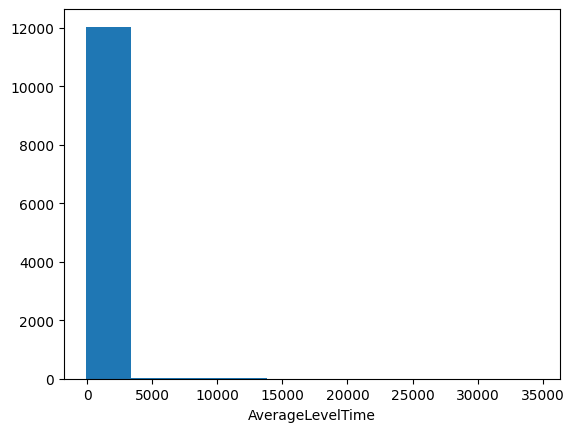

In [ ]:
f, ax = plt.subplots()
ax.hist(plot_data)
ax.set_xlabel(feature_to_visualize)

### Simple feature comparison scatterplot

In [ ]:
x_axis_feature = "AverageFails"
minimum_x_value = -math.inf
maximum_x_value = math.inf
y_axis_feature = "AverageLevelTime"
minimum_y_value = -math.inf
maximum_y_value = math.inf

range_filter = (df_session[x_axis_feature] > minimum_x_value) & (df_session[x_axis_feature] < maximum_x_value) \
             & (df_session[y_axis_feature] > minimum_y_value) & (df_session[y_axis_feature] < maximum_y_value)
scatter_data = df_session[[x_axis_feature, y_axis_feature]][range_filter]
print(scatter_data.describe())

       AverageFails  AverageLevelTime
count  10214.000000      10214.000000
mean       4.395034        122.963401
std        5.955671        863.582203
min        1.000000        -66.135500
25%        2.125000         19.306933
50%        3.000000         36.724239
75%        4.555556         65.492238
max      284.000000      34555.889000


Text(0, 0.5, 'AverageLevelTime')

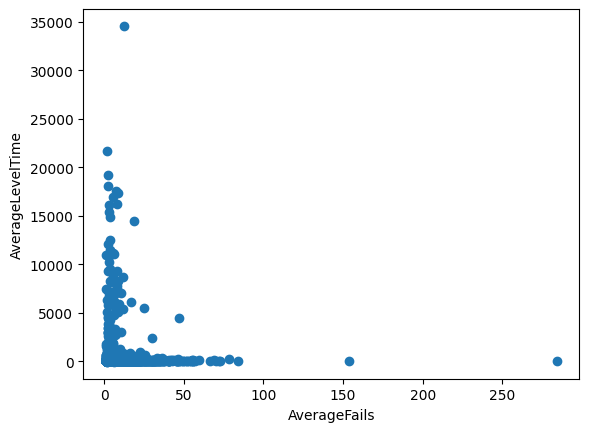

In [ ]:
f, ax = plt.subplots()
ax.scatter(scatter_data[x_axis_feature], scatter_data[y_axis_feature])
ax.set_xlabel(x_axis_feature)
ax.set_ylabel(y_axis_feature)

## How Many Players?

In [ ]:
# Not just "how many played at all", but "how many played and completed at least one level", or "played at least one minute."
level_completion_columns = df_session[df_session.columns[df_session.columns.str.endswith("Completed")]]

per_player_levels_completed = level_completion_columns.sum(axis=1)

In [ ]:
print(f"There were {df_session.shape[0]} sessions in the dataset (after cleaning).\nOf those, {per_player_levels_completed[per_player_levels_completed >= 1].shape[0]} sessions completed at least one level.")

There were 12099 sessions in the dataset (after cleaning).
Of those, 11507 sessions completed at least one level.


## How Far Did They Get?

Text(0.5, 1.0, 'Histogram for # of Different Levels Completed')

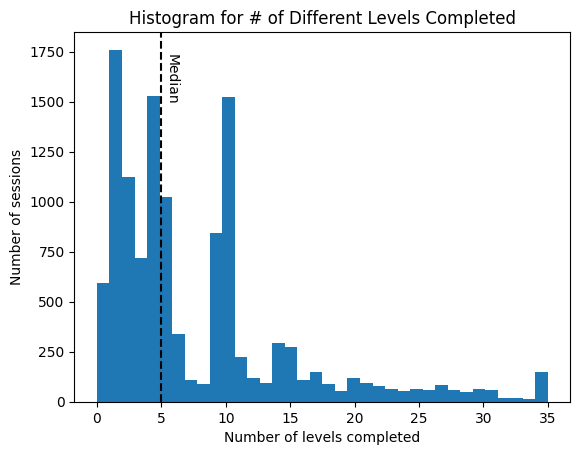

In [ ]:
f, ax = plt.subplots()
ax.hist(per_player_levels_completed, bins=36)
ax.axvline(x=per_player_levels_completed.median(), linestyle='--', color='k', label="Median")
ax.text(x=per_player_levels_completed.median() + 0.25, y=1500, s="Median", rotation=-90)
ax.set_xlabel("Number of levels completed")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for # of Different Levels Completed")

Text(0.5, 1.0, 'Number of Players Completing Each Level')

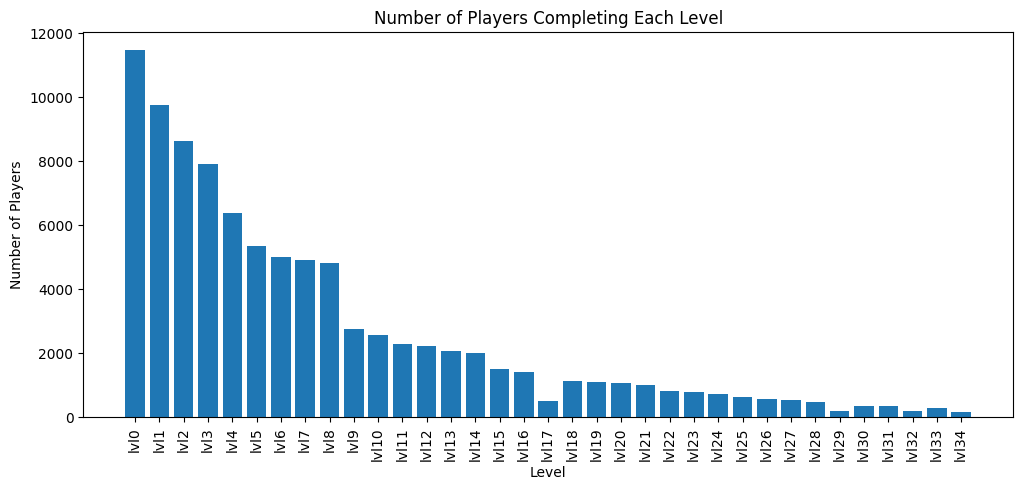

In [ ]:
per_level_completions = level_completion_columns.sum(axis=0)
f,ax = plt.subplots(figsize=(12, 5))
ax.bar([col.split('_')[0] for col in level_completion_columns.columns], per_level_completions)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Level")
ax.set_ylabel("Number of Players")
ax.set_title("Number of Players Completing Each Level")

## How Long Did They Play?

In [ ]:
time_feature = "AverageLevelTime"
df_session[time_feature].describe()

count    12099.000000
mean       105.725985
std        794.665767
min        -66.135500
25%         12.879889
50%         30.919700
75%         58.941682
max      34555.889000
Name: AverageLevelTime, dtype: float64

In [ ]:
minimum_value = 0
maximum_value = 1000

range_filter = (df_session[time_feature] > minimum_value) & (df_session[time_feature] < maximum_value)
time_data = df_session[time_feature][range_filter]
time_data.describe()

count    11380.000000
mean        50.337773
std         70.517608
min          0.736000
25%         14.934000
50%         32.515750
75%         59.652925
max        963.014556
Name: AverageLevelTime, dtype: float64

Text(0.5, 1.0, 'Histogram for Average Time Per Level')

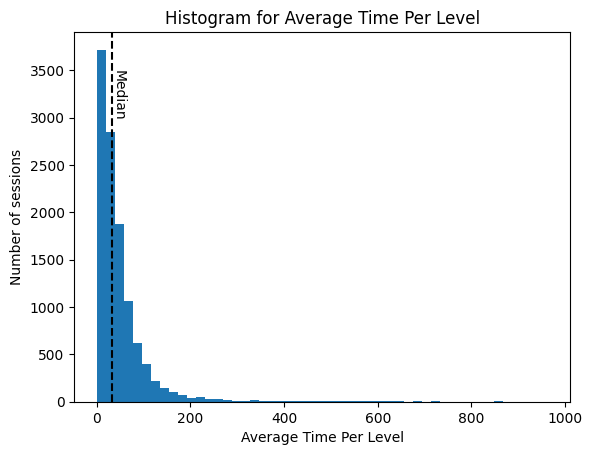

In [ ]:
f, ax = plt.subplots()
ax.hist(time_data, bins=50)
ax.axvline(x=time_data.median(), linestyle='--', color='k', label="Median")
ax.text(x=time_data.median() + 0.25, y=3000, s="Median", rotation=-90)
ax.set_xlabel("Average Time Per Level")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Average Time Per Level")

In [ ]:
level_time_columns = df_session[df_session.columns[df_session.columns.str.endswith("TotalLevelTime")]]

per_player_total_time = level_time_columns.sum(axis=1)
per_player_total_time.describe()

count     12099.000000
mean       1183.262604
std        9543.908709
min        -249.544000
25%          42.459500
50%         219.347000
75%         656.041500
max      489750.058000
dtype: float64

In [ ]:
minimum_value = 0
maximum_value = 5000

range_filter = (per_player_total_time > minimum_value) & (per_player_total_time < maximum_value)
total_time_data = per_player_total_time[range_filter]
total_time_data.describe()

count    11278.000000
mean       476.923657
std        648.393231
min          1.289000
25%         54.458000
50%        237.053500
75%        652.023750
max       4982.467000
dtype: float64

Text(0.5, 1.0, 'Histogram for Total Play Times')

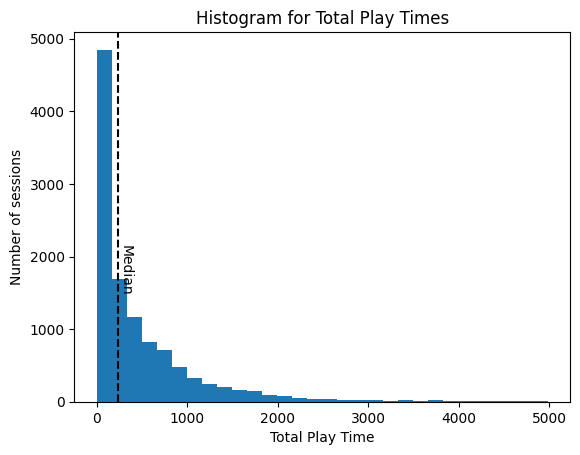

In [ ]:
f, ax = plt.subplots()
ax.hist(total_time_data, bins=30)
ax.axvline(x=total_time_data.median(), linestyle='--', color='k', label="Median")
ax.text(x=total_time_data.median() + 0.25, y=1500, s="Median", rotation=-90)
ax.set_xlabel("Total Play Time")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Total Play Times")

Text(0.5, 1.0, 'Total Time Played in each Level')

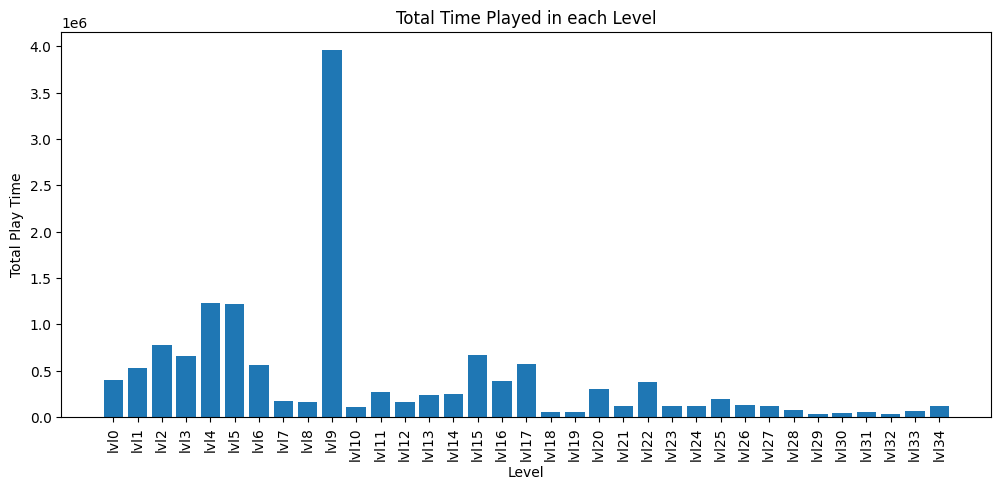

In [ ]:
per_level_total_time = level_time_columns.sum(axis=0)

f,ax = plt.subplots(figsize=(12, 5))
ax.bar([col.split('_')[0] for col in level_completion_columns.columns], per_level_total_time)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Level")
ax.set_ylabel("Total Play Time")
ax.set_title("Total Time Played in each Level")

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [ ]:
#@markdown Choose your own metric for test here
response_variable = "AverageFails"
min_response_val = 0
max_response_val = 20
independent_variable = "AverageMoveTypeChanges" #@param {type:'string'}
min_independent_val = 0
max_independent_val = 6
# Dividing_value = "20" #@param {type: 'string'}
comparison_data = df_session[[response_variable, independent_variable]]
comparison_data = comparison_data[(df_session[response_variable] >= min_response_val) & (df_session[response_variable] <= max_response_val)
                                & (df_session[independent_variable] >= min_independent_val) & (df_session[independent_variable] <= max_independent_val)]
response_data = np.log(comparison_data[response_variable])
independent_data = comparison_data[independent_variable]

Text(0.5, 1.0, 'Histogram for AverageMoveTypeChanges')

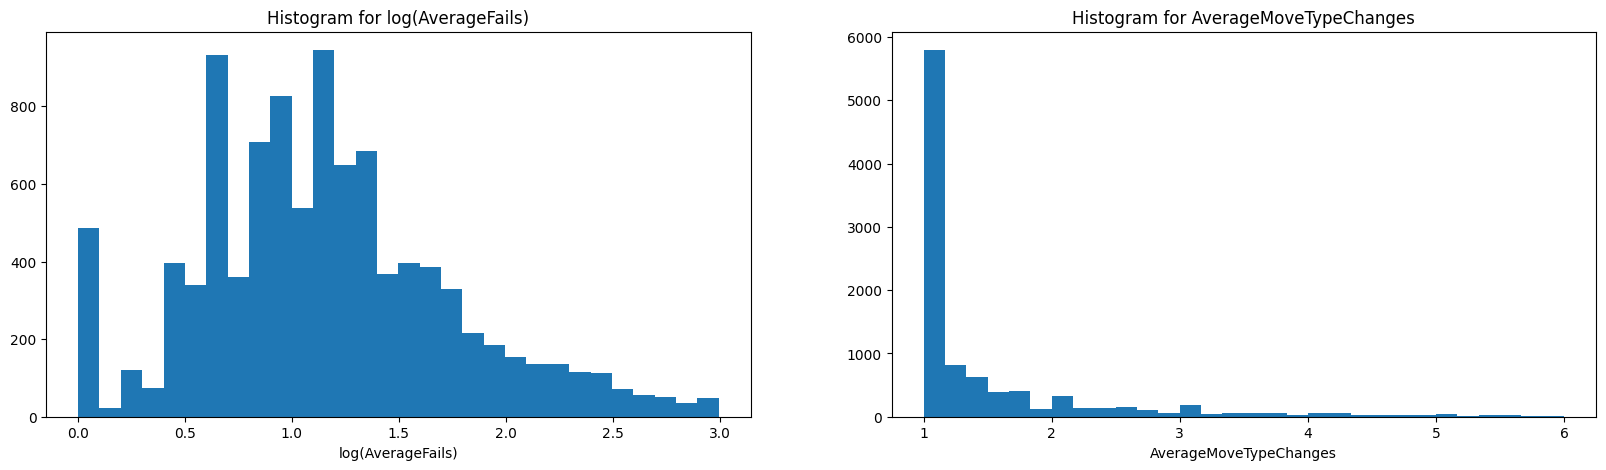

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].hist(response_data, bins=30)
ax[0].set_xlabel(f"log({response_variable})")
ax[0].set_title(f"Histogram for log({response_variable})")
ax[1].hist(independent_data, bins=30)
ax[1].set_xlabel(independent_variable)
ax[1].set_title(f"Histogram for {independent_variable}")

In [ ]:
group_data = independent_data.ge(independent_data.mean())
group_data.describe()
# independent_data.describe()

count      9874
unique        2
top       False
freq       7225
Name: AverageMoveTypeChanges, dtype: object

In [ ]:
pairwise = pairwise_tukeyhsd(endog=response_data, groups=group_data, alpha=0.05)
print(pairwise)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 False   True   0.0109 0.4191 -0.0156 0.0374  False
---------------------------------------------------
